In [1]:
import os, sys
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

from util import basic


In [2]:
pos_data, pos_label = basic.preprocess_data("/home/moamin/sequence_annotation_seawulf/gene_range_start_codon.txt", 1)
neg_data, neg_label = basic.preprocess_data("/home/moamin/sequence_annotation_seawulf/intragenic_start_codon.txt", 0)

In [3]:
print(len(pos_data), len(neg_data))
print(pos_label[0], neg_label[0])
batch_size = 5000

8385 13683
1 0


In [4]:
data_content = pos_data[:batch_size] + neg_data[:batch_size]
data_label = pos_label[:batch_size] + neg_label[:batch_size] 
print(len(data_content), np.sum(data_label))

rand_index = np.random.permutation(len(data_content))
data_content = [data_content[i] for i in rand_index]
data_label = [data_label[i] for i in rand_index]
print(len(data_content), np.sum(data_label))

for i in range(len(data_label)):
    if data_label[i] == 1:
        data_content[i] = [data_content[i][0] for k in data_content[i]]
    

10000 5000
10000 5000


In [5]:
np.array(data_content)

array([['2', '1', '1', ..., '1', '4', '4'],
       ['3', '2', '3', ..., '1', '3', '1'],
       ['4', '4', '4', ..., '4', '4', '4'],
       ...,
       ['4', '4', '4', ..., '4', '4', '4'],
       ['2', '4', '4', ..., '1', '3', '3'],
       ['2', '2', '1', ..., '4', '4', '4']], dtype='<U1')

In [6]:
np.array(data_label)

array([0, 0, 1, ..., 1, 0, 0])

## Pytorch base line model

In [7]:
X = torch.from_numpy(np.array(data_content).astype(int))
Y = torch.from_numpy(np.array(data_label).reshape(len(data_label),1).astype(int))
X.shape, Y.shape

(torch.Size([10000, 101]), torch.Size([10000, 1]))

In [8]:
class LSTMTagger(nn.Module):

    def __init__(self, time_steps, embedding_dim, hidden_dim, vocab_size, tagset_size, mini_batch):
        super(LSTMTagger, self).__init__()
        self.time_steps = time_steps
        self.hidden_dim = hidden_dim
        self.mini_batch = mini_batch
        self.hidden = self.init_hidden()
        
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm_one = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout_one = nn.Dropout(0.25)
        self.lstm_two = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.dropout_two = nn.Dropout(0.25)

        # The linear layer that maps from hidden state space to tag space
        #self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.hidden2tag_one = nn.Linear(hidden_dim*time_steps, 512)
        self.dropout_three = nn.Dropout(0.25)
        self.hidden2tag_two = nn.Linear(512, 128)
        self.dropout_four = nn.Dropout(0.25)
        self.hidden2tag_three = nn.Linear(128, 64)
        self.dropout_five = nn.Dropout(0.25)
        
        self.output = nn.Linear(64, tagset_size)

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(1, self.mini_batch, self.hidden_dim),
                torch.zeros(1, self.mini_batch, self.hidden_dim))
        
    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)#.view(len(sentence), self.mini_batch, -1)
        lstm_out, self.hidden_one = self.lstm_one(embeds, self.hidden)
        lstm_out = self.dropout_one(lstm_out)
        lstm_out, self.hidden_two = self.lstm_two(lstm_out, self.hidden)
        lstm_out = self.dropout_two(lstm_out)
        
        #print(lstm_out.shape)
        #print(self.hidden)
        
        #print(lstm_out[:, -1].shape)
        #tag_space = self.hidden2tag(lstm_out[:, -1])
        
        lstm_out = lstm_out.contiguous().view(self.mini_batch, -1)
        #print(lstm_out.shape)
        
        
        dense_out = self.hidden2tag_one(lstm_out[:])
        dense_out = F.relu(dense_out[:])
        dense_out = self.dropout_three(dense_out[:])
        
        dense_out = self.hidden2tag_two(dense_out[:])
        dense_out = F.relu(dense_out[:])
        dense_out = self.dropout_four(dense_out[:])
        
        dense_out = self.hidden2tag_three(dense_out[:])
        dense_out = F.relu(dense_out[:])
        dense_out = self.dropout_five(dense_out[:])
        
        tag_space = self.output(dense_out[:])
        #print(tag_space.shape)
        #tag_scores = F.sigmoid(tag_space)
        tag_scores = F.softmax(tag_space, dim=1)
        #print(tag_scores.shape)
        return tag_scores


In [9]:
model = LSTMTagger(101, 16, 16, 5, 1, batch_size)
print(model)
opt = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
opt = optim.SGD(model.parameters(), lr=0.1)  

LSTMTagger(
  (word_embeddings): Embedding(5, 16)
  (lstm_one): LSTM(16, 16, batch_first=True)
  (dropout_one): Dropout(p=0.25)
  (lstm_two): LSTM(16, 16, batch_first=True)
  (dropout_two): Dropout(p=0.25)
  (hidden2tag_one): Linear(in_features=1616, out_features=512, bias=True)
  (dropout_three): Dropout(p=0.25)
  (hidden2tag_two): Linear(in_features=512, out_features=128, bias=True)
  (dropout_four): Dropout(p=0.25)
  (hidden2tag_three): Linear(in_features=128, out_features=64, bias=True)
  (dropout_five): Dropout(p=0.25)
  (output): Linear(in_features=64, out_features=1, bias=True)
)


In [10]:
with torch.no_grad():
    # inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(X[:batch_size])
    print(len(tag_scores))

5000


### Could not solve simpler task: [same numbers] -> 1; [different_numbers] -> 0

In [11]:
from tqdm import tqdm_notebook as tqdm
losses = []
for epoch in tqdm(range(10)):  # again, normally you would NOT do 300 epochs, it is toy data
    total_loss = 0
    for index in range(0, len(X), batch_size):
        sentence = X[index : index+batch_size]
        tags = Y[index : index+batch_size]
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        model.hidden = model.init_hidden()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        # sentence_in = prepare_sequence(sentence, word_to_ix)
        #targets = prepare_sequence(tags, tag_to_ix)
        targets = tags.float().flatten()

        # Step 3. Run our forward pass.
        tag_scores = model(sentence).flatten()
        #print(targets.shape, tag_scores.shape)
        

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = criterion(tag_scores, targets)
        total_loss += loss.data.numpy()
        
        loss.backward()
        opt.step()
        
    #total_loss.backward()
    #opt.step()
    print(epoch, total_loss)
        
    losses.append(total_loss/len(X))
        

0 27.63189697265625
1 27.63189697265625
2 27.63189697265625
3 27.63189697265625
4 27.63189697265625
5 27.63189697265625
6 27.63189697265625
7 27.63189697265625
8 27.63189697265625
9 27.63189697265625



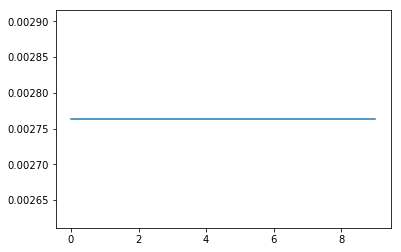

In [12]:
plt.plot(losses)

# Keras Implementation

In [13]:
import os, sys
import random, h5py
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers.recurrent import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.optimizers import SGD

#Initialize the Program
alphabet = "NACGT."
vocab_size = 6
batch_size = 1000
embedding_size = 4
time_steps = 101
category = 2
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))


Using TensorFlow backend.


In [14]:
data_content = pos_data[:batch_size] + neg_data[:batch_size]
data_label = pos_label[:batch_size] + neg_label[:batch_size] 
print(len(data_content), np.sum(data_label))

2000 1000


In [15]:
from keras.layers import Input, Embedding
from keras.layers import Reshape, Dense
from keras.models import Model

max_source_len = len(data_content[0])
embedding_size = 5
lstm_unit = 16

input_source = Input(shape=(max_source_len,), \
                     dtype='int32', name='main_input')
embedding = Embedding(input_dim=vocab_size, \
                      output_dim=embedding_size, \
                      input_length=max_source_len, \
                      name='embedding')(input_source)

lstm_layer = LSTM(lstm_unit, return_sequences=True)(embedding)
lstm_layer = Dropout(0.25)(lstm_layer)
lstm_layer = LSTM(lstm_unit, return_sequences=True)(lstm_layer)
lstm_layer = Dropout(0.25)(lstm_layer)

reshape_layer = Reshape((max_source_len*lstm_unit,))(lstm_layer)

dense_layer_first = Dense(512, activation='relu', \
                        name='fstlayer')(reshape_layer)
dense_layer_first = Dropout(0.25)(dense_layer_first)

dense_layer_mid = Dense(128, activation='relu', \
                        name='midlayer')(dense_layer_first)
dense_layer_mid = Dropout(0.25)(dense_layer_mid)

dense_layer = Dense(64, activation='relu', \
                    name='finlayer')(dense_layer_mid)
dense_layer = Dropout(0.25)(dense_layer)

dense_output = Dense(1, activation='sigmoid', \
                     name='output')(dense_layer)

model = Model(inputs=[input_source], outputs=[dense_output])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 101)               0         
_________________________________________________________________
embedding (Embedding)        (None, 101, 5)            30        
_________________________________________________________________
lstm_1 (LSTM)                (None, 101, 16)           1408      
_________________________________________________________________
dropout_1 (Dropout)          (None, 101, 16)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 101, 16)           2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 101, 16)           0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1616)              0         
__________

In [16]:
from keras_tqdm import TQDMNotebookCallback
print('Train...')

history = model.fit(np.array(data_content), np.array(data_label), \
          validation_split=0.2, shuffle=True, \
          epochs=10, batch_size=100, verbose=2, \
           callbacks=[TQDMNotebookCallback()])


Train...
Train on 1600 samples, validate on 400 samples
Epoch 1/10
 - 5s - loss: 0.6680 - acc: 0.6187 - val_loss: 0.8856 - val_acc: 0.0000e+00
Epoch 2/10
 - 3s - loss: 0.6529 - acc: 0.6250 - val_loss: 0.8099 - val_acc: 0.0000e+00
Epoch 3/10
 - 3s - loss: 0.5730 - acc: 0.6925 - val_loss: 0.7981 - val_acc: 0.6950
Epoch 4/10
 - 3s - loss: 0.4835 - acc: 0.7862 - val_loss: 0.5406 - val_acc: 0.7775
Epoch 5/10
 - 3s - loss: 0.4189 - acc: 0.8125 - val_loss: 0.5129 - val_acc: 0.7300
Epoch 6/10
 - 3s - loss: 0.3718 - acc: 0.8531 - val_loss: 0.6696 - val_acc: 0.6775
Epoch 7/10
 - 3s - loss: 0.3345 - acc: 0.8669 - val_loss: 0.4823 - val_acc: 0.7600
Epoch 8/10
 - 3s - loss: 0.3094 - acc: 0.8744 - val_loss: 0.4986 - val_acc: 0.7650
Epoch 9/10
 - 3s - loss: 0.2826 - acc: 0.8850 - val_loss: 0.4109 - val_acc: 0.8200
Epoch 10/10
 - 3s - loss: 0.2688 - acc: 0.8969 - val_loss: 0.6004 - val_acc: 0.7400



dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
11 11


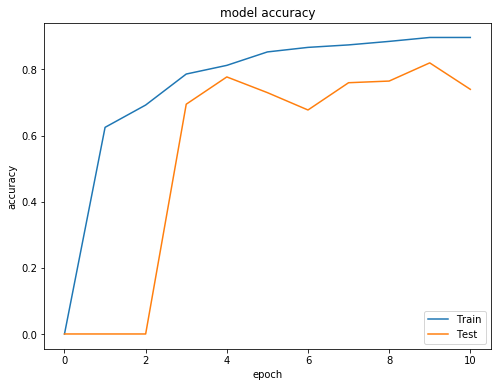

In [17]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
train = history.history['acc']
valid = history.history['val_acc']

x = [0.] + train[1:] + [train[-1]]
y = [0.] + valid[:-1] + [valid[-1]]
print(len(x), len(y))

plt.figure(figsize=(8, 6))
plt.plot(x)
plt.plot(y)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()
